<a href="https://colab.research.google.com/github/Lawrence-Krukrubo/Anomaly_Detection_in_Time_Series_Data_with_Keras/blob/master/anomaly_detection_in_time_series_data_with_keras_and_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><b>Anomaly Detection:</b></h1>
In the most general sense, Anomaly detection is the task of detecting rare events or outliers in the data. It has a lot of applications in the financial sector. Such as <em>bank-fraud-risk-detection-models</em>. It also applies to multiple domains aside Finance, such as Medical Sector, where it can be applied to <em>medical-imaging</em>, and <em>intrusion-detection-system</em> for Cyber-security, and even in sensory networks and so on. 

<h3><b>Task 1: Import Libraries</b></h3>

In [97]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14,8
np.random.seed(1)
tf.random.set_seed(1)

print('tensorflow version:',tf.__version__)

tensorflow version: 2.2.0


<h3><b>Task 2: Load and Inspect the S&P 500 Index Data</b><h3>

In [0]:
data_link = 'https://raw.githubusercontent.com/Lawrence-Krukrubo/Anomaly_Detection_in_Time_Series_Data_with_Keras/master/spx.csv'

In [99]:
# next let's load the data in a pandas Data Frame
df = pd.read_csv(data_link, parse_dates=['date'])  # We parse the date column so it takes the date-time format
df.head()

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


In [100]:
df.shape

(8192, 2)

Next, let's visualize the closing prices from 1986 to 2018, using an interactive plotly chart. Plotly will allow us zoom in the graph and look at specific time-slices if we want to.

In [101]:
# first we use the plotly.graph method as go, to create an empty figure
fig = go.Figure()

# Next we populate the figure by adding trace. Trace lets us add different types of plots to the same figure.
# We will create a line plot by passing mode='lines' to the go.Scatter function. 
# Note if we wanted to create a scatter plot we'd pass mode='marker'instead.
# Finally, we'd set our legend value to the close column i.e name='close'

fig.add_trace(go.Scatter(x=df.date, y=df.close, mode='lines', name='close'))

# Next we update our figure layout to show the legend
fig.update_layout(showlegend=True)
fig.show()

Note: To automatically zoom in to the chart, just click and drag to create a rectangle over the chart area you're interested in.<br>To zoom out hover over the top right of the chart and select the icon auto-scale to return to default map or zoom out to go reduce zoom level.

<h3><b>Task 3: Data Preprocessing</b></h3>

We shall do some data-preprocessing that will involve
1. Standardizing the target-vector by removing the mean and scaling it to the unit variance, using the standard_scaler function from sklearn.preprocessing
2. We need to split the data to training and testing sets, which we must do before standardizing it

In [102]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size

train_set = df.iloc[0:train_size]
test_set = df.iloc[train_size: len(df)]

print(f"The shape of train_set is: {train_set.shape}, and test_set is: {test_set.shape}")

The shape of train_set is: (6553, 2), and test_set is: (1639, 2)


Now let's standardize the data set.
1. first we import and instantiate standard_scaler, 
2. Then fit the train set `close` feature to standard_scaler
3. Then transform the train set `close` feature by standard scaler
4. Then we transform test set `close` feature too.

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  # Instantiate SC

# Next we fit scaler on training data to learn its statistical properties, 
# Then we transform both train and test data with these statistical properties.
scaler.fit(train_set[['close']]) # Use double square brackets for 2D array.

train_set['close'] = scaler.transform(train_set[['close']])
test_set['close'] = scaler.transform(test_set[['close']])

In [104]:
# Let's see the first few standardized data.
train_set.head()

,date,close
0,1986-01-02,-1.516118
1,1986-01-03,-1.513027
2,1986-01-06,-1.513578
3,1986-01-07,-1.506029
4,1986-01-08,-1.520001


Since this is a time-series modelling project, we need to split our data into sub-sequences before using it to train our model. We can create sequences with specific time-steps. In our case we set `time_steps=30`. Meaning we create sequences with 30 days worth of historical data. 
<br>And as required by LSTM networks, we need to reshape our data into the shape `n_samples` by `n(time_steps)` by `n(features)`.<br> 
Here, our `n(features)`is just one and `n(time_steps)` is 30.

<h3><b>Task 4: Temporalize Data and create Training and Test splits</b></h3>

As stated above, dealing with LSTM networks, we need to temporalize our data, and reshape our data. Let's define a simple method that can help us, since we must repeat same process for `X_train`, `X_test`, `y_train` and `y_test` arrays.

In [0]:
def create_sequence(X, y, time_steps=1):
    """ Reshape data for LSTM network.

    @Param:
    X is the feature of the training set
    y is the target of the training,
    Note that X and y are identical in this
    Case given only `close` feature.

    @Return:
    Return X and y which are both arrays, 
    reshaped by:
    n_samples by n_timesteps by n_features

    """

    Xs, ys = [], []

    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i: i + time_steps].values)
        ys.append(y.iloc[i + time_steps])
    
    return np.array(Xs), np.array(ys)

In [106]:
# Next let's create our X_train and x_test, y_train and y_test

time_steps = 30

X_train, y_train = create_sequence(train_set[['close']], train_set['close'], time_steps)
X_test, y_test = create_sequence(test_set[['close']], test_set['close'], time_steps)

# Let's see the first index of X_train and y_train
print('X_train last index is:\n', X_train[-1],'\ny_train last index is:\n', y_train[-1])

X_train last index is:
 [[0.92720661]
 [0.95258626]
 [1.01048734]
 [0.98156076]
 [0.99601207]
 [0.9459238 ]
 [0.89612312]
 [0.89497277]
 [0.84064258]
 [0.82880353]
 [0.76589363]
 [0.75841634]
 [0.83961205]
 [0.84593899]
 [0.97000931]
 [0.96430548]
 [0.96358651]
 [0.99426257]
 [0.9975938 ]
 [1.00368109]
 [0.93978859]
 [0.98973306]
 [0.94486931]
 [0.91913017]
 [0.88579392]
 [0.89521243]
 [0.90458301]
 [0.87028812]
 [0.95644473]
 [0.96224443]] 
y_train last index is:
 0.9868811449578108


Next, let's print out the shape of our training and testing sets

In [107]:
print(f'X_train shape is: {X_train.shape}, y_train shape is: {y_train.shape}')
print(f'X_test shape is: {X_test.shape}, y_test shape is: {y_test.shape}')

X_train shape is: (6523, 30, 1), y_train shape is: (6523,)
X_test shape is: (1609, 30, 1), y_test shape is: (1609,)


So we can see that our training and test arrays have the right shapes. <br>For example `X_train` has a shape in form of (`n_samples` by `n_steps` by `n_features`). just as expected.
<br>Let's start building our LSTM auto-encoder

<h3><b>Task 5: Build an LSTM Auto-Encoder in Keras</b></h3>

Here we'd build an LSTM auto-encoder network and visualize its architecture and data flow. Here are the steps:
1. We train an auto-encoder on data with no anomalies
2. Then take a new data point and try to reconstruct it using the auto-encoder
3. If the reconstruction error for the new data point is above some set threshold, we'd label that data point as an anomaly.
LSTMs work fantastically with Data that has temporal properties to them.

In [0]:
# Let's define variables we'd need for our LSTM as a function of Training data.

timesteps = X_train.shape[1]
num_features = X_train.shape[2]

In [0]:
# Let's import the required building libraries

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed

In [0]:
# Next we use the Sequential layer and basically stack all needed layers in it.

model = Sequential([
    # We pass the input shape to the model
    LSTM(128, input_shape=(timesteps, num_features)),
    Dropout(0.2),

    # If subsequent layer is an LSTM, we need to duplicate 
    # This using the repeatVector layer. This replicates the 
    # Feature vector from the LSTM layer output, timesteps times.
    RepeatVector(timesteps),

    # The encoder has been done, now we mirror the encoder 
    # in reverse fashion.These are the steps for creating 
    # The decoder. Note the RepeatVector layer acts as a bridge
    # Between the encoding and the decoding modules. It prepares 
    # The 2D array input for first LSTM layer in decoder. 
    LSTM(128, return_sequences=True),

    # The return_sequence=True makes each timestep return a 
    # signal. Let's add another dropout layer
    Dropout(0.2),

    # Next we add the timedistributed layer (TDL) at the end,
    # So we get the output with the right shape
    TimeDistributed(Dense(num_features))
        
    # TDL creates a vector of length=num_features outputted from
    # The previous layer. Since prev layer outputs 128 features,
    # TDL creates a 128 long vector and duplicates it the
    # num_feature times.
])

In [111]:
# Next let's compile the model

model.compile(loss = 'mae', optimizer = 'adam')
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
repeat_vector_17 (RepeatVect (None, 30, 128)           0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 30, 128)           131584    
_________________________________________________________________
dropout_21 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_______________________________________________

<h3><b>Task 3: Train the Auto-Encoder</b></h3>

Time to train the model, after compiling it. Let's apply the early stopper regularization technique called call_backs. This way, we don't need to hard-code the number of epochs the model will train on. Rather by specifying a metric to watch, we can stop training the moment the model stops improving in learning and starts over-fitting.

In [0]:
# This is one way to implement the callback function based on achieving,
# A certain level of performance. But we'd use the one below.

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.9):
            print("\nReached 90% accuracy so cancelling training!")
            self.model.stop_training = True

The code below means, we monitor the validation loss metric and if it's not reducing for 3 consecutive epochs, then we stop the training and take the minimum validation loss parameters.

In [0]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

In [114]:
# Next, let's train the model. Batch size is the number of features the model
# Should train before updating its weights. It's a hyper-par we can sure tweak.
# We set epochs real high to give leeway for callbacks to work.
# validation_split:- keep specified percent for validating, use rest to train
# Make sure value of callback is in a list.
# Finally, dont shuffle time-series data. order matters. So, shuffle=False

model.fit(
    X_train,
    y_train,
    epochs = 1000,
    batch_size = 32,
    callbacks = [callback],
    validation_split = 0.1,
    shuffle = False
)

Epoch 1/1000
184/184 [==============================] - 2s 9ms/step - loss: 0.1650 - val_loss: 0.1764
Epoch 2/1000
184/184 [==============================] - 1s 6ms/step - loss: 0.1136 - val_loss: 0.0569
Epoch 3/1000
184/184 [==============================] - 1s 6ms/step - loss: 0.0902 - val_loss: 0.0510
Epoch 4/1000
184/184 [==============================] - 1s 6ms/step - loss: 0.0806 - val_loss: 0.0539
Epoch 5/1000
184/184 [==============================] - 1s 6ms/step - loss: 0.0763 - val_loss: 0.0447
Epoch 6/1000
184/184 [==============================] - 1s 6ms/step - loss: 0.0778 - val_loss: 0.0468
Epoch 7/1000
184/184 [==============================] - 1s 6ms/step - loss: 0.0753 - val_loss: 0.0790
Epoch 8/1000
184/184 [==============================] - 1s 6ms/step - loss: 0.0768 - val_loss: 0.0389
Epoch 9/1000
184/184 [==============================] - 1s 6ms/step - loss: 0.0717 - val_loss: 0.0282
Epoch 10/1000
184/184 [==============================] - 1s 6ms/step - loss: 0.072

<h3><b>Task 7: Plot Metrics and Evaluate the Model</b></h3>

Let's now plot our metrics, which is the training loss and validation loss. We use matplotlib this time, since we have no need for interactive plots. Loss values are stored in the history.history object. So we can use this to plot the losses. The history object is a dictionary so we choose the keys we want to plot.

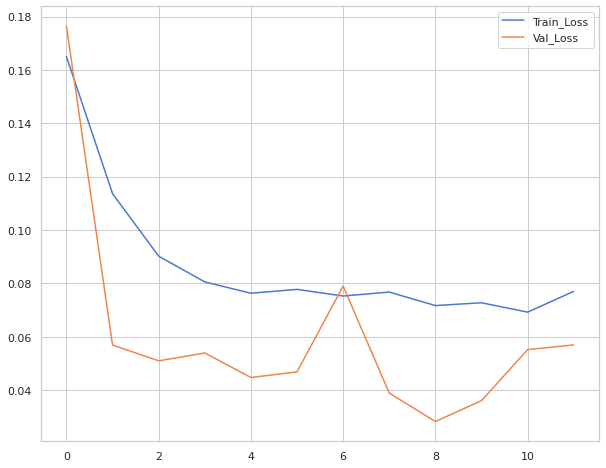

In [115]:
plt.figure(figsize=(10,8))
plt.plot(model.history.history['loss'], label='Train_Loss')
plt.plot(model.history.history['val_loss'], label='Val_Loss')
plt.legend()  # Show the legend
plt.show()

Here we can see that our validation loss was consistently lower than training loss. This means we under-fit on the training data. We can adjust this by tweaking on some of the hyper-parameters like model architecture and batch size and others

Well, we still need to detect anomalies in our test data. So let's make some predictions and calculate the MAE on the training data.

In [116]:
# First let's get some predictions on the training data
X_train_pred = model.predict(X_train)

# Next let's compute the mean absolute error of X_train_pred and X_train.
# MAE is so easy to compute:- find mean of abs(X_train_pred - X_train)
# Let's save it in a Data Frame

train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Errors'])

train_mae_loss.head()

,Errors
0,0.517819
1,0.518320
2,0.519914
3,0.522037
4,0.520630


Next, let's evaluate the model on the test data

In [117]:
model.evaluate(X_test, y_test)

# Model.evaluate shows us the total loss for the predictions. While the MAE we computed above was for each prediction.
# This loss is 0.37 for the test data 

51/51 [==============================] - 0s 3ms/step - loss: 0.3665


0.36646005511283875

Let's see the distribution of the MAE loss for the train data

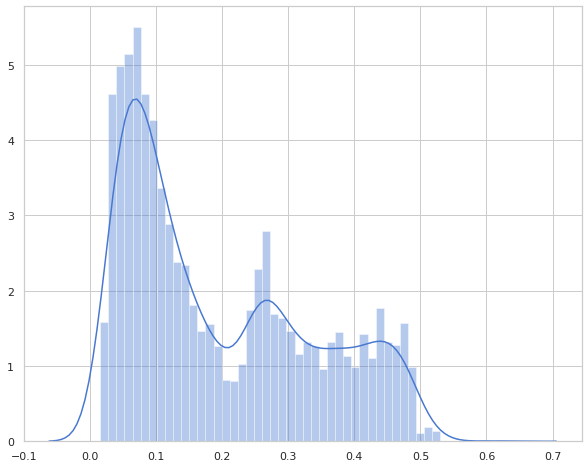

In [118]:
plt.figure(figsize=(10,8))
sns.distplot(train_mae_loss, bins=50, kde=True) # kde is kernel density estimate tht's over laid on the distplot.
plt.show()

Okay, so let's set a threshold of say 0.65 on the x_axis. This means any data above 0.6 is considered and labeled an anomaly

In [0]:
threshold = 0.65

next, lets compute the test MAE just as we did the train one

In [0]:
# First let's get some predictions on the testing data
X_test_pred = model.predict(X_test)

# Next let's compute the mean absolute error of X_test_pred and X_test.
# MAE is so easy to compute:- find mean of abs(X_test_pred - X_test)
# Let's save it in a Data Frame

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

<b><h3>Task 8: Detect Anomalies in the S&P 500 Index Data:</b></h3>

1. First we build a data frame with the loss and anomaly values(those exceeding the treshold)
2. The data will begin after the time steps in the original test data set

In [0]:
test_score_df = pd.DataFrame(test_set[time_steps:])

Now let's add some other important columns in this data frame

In [0]:
# First lets add the loss column containing the test_mae_loss
test_score_df['loss'] = test_mae_loss

# Next, we set the threhold column
test_score_df['threshold'] = threshold

# next let's create an is_anomaly column that tells if a loss is above or equal 
# to the threshols set
test_score_df['is_anomaly'] = test_score_df.loss >= test_score_df.threshold

# lastly, let's track the closing prices
test_score_df['close'] = test_set[time_steps:].close

In [123]:
# Let's see the first 10 rows
test_score_df.head(10)

,date,close,loss,threshold,is_anomaly
6583,2012-02-08,1.216856,0.056148,0.65,False
6584,2012-02-09,1.221625,0.056178,0.65,False
6585,2012-02-10,1.199313,0.056055,0.65,False
6586,2012-02-13,1.221194,0.056090,0.65,False
6587,2012-02-14,1.218150,0.054610,0.65,False
6588,2012-02-15,1.200727,0.053663,0.65,False
6589,2012-02-16,1.236220,0.058030,0.65,False
6590,2012-02-17,1.243865,0.052820,0.65,False
6591,2012-02-21,1.246214,0.050520,0.65,False
6592,2012-02-22,1.235309,0.050771,0.65,False


In [124]:
# Let's see the last 10 rows
test_score_df.tail(10)

,date,close,loss,threshold,is_anomaly
8182,2018-06-18,4.629065,0.654939,0.65,True
8183,2018-06-19,4.602319,0.672143,0.65,True
8184,2018-06-20,4.613655,0.696546,0.65,True
8185,2018-06-21,4.571571,0.704774,0.65,True
8186,2018-06-22,4.583842,0.729817,0.65,True
8187,2018-06-25,4.493228,0.734083,0.65,True
8188,2018-06-26,4.507583,0.779650,0.65,True
8189,2018-06-27,4.451431,0.789795,0.65,True
8190,2018-06-28,4.491406,0.819372,0.65,True
8191,2018-06-29,4.496343,0.808718,0.65,True


Let's visualize the test_mae_loss

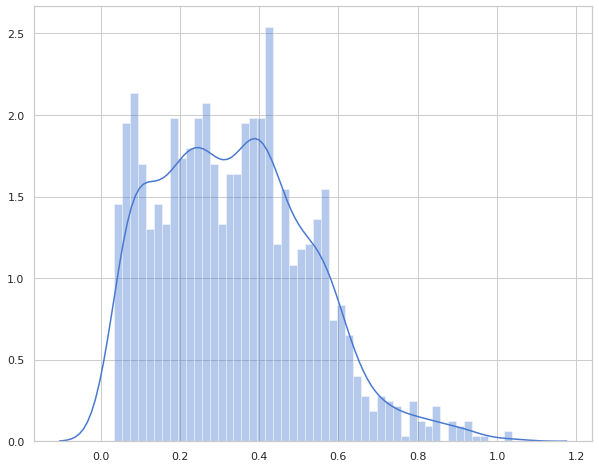

In [125]:
plt.figure(figsize=(10,8))
sns.distplot(test_mae_loss, bins=50, kde=True) # kde is kernel density estimate tht's over laid on the distplot.
plt.show()

Okay at this point let's do some visualization, using plotly. To see what values in the test set fall under the anomaly or not

In [126]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = test_score_df.date, 
                         y = test_score_df.loss, 
                         mode='lines', 
                         name='Test_Loss'))

# Let's create another line chart to plot the threshold at 0.65
fig.add_trace(go.Scatter(x = test_score_df.date, 
                         y = test_score_df.threshold, 
                         mode='lines', 
                         name='Threshold'))

# Let's update the figure with the legend
fig.update_layout(showlegend=True)
fig.show()

It looks really cool. And seems like we are thresholding extreme values really well. All the values above the threshold are considered anomalies because their reconstruction error esceeds the threshold of 0.65

So let's create a Dataframe with only the extreme values and plot them and explore them with more granularity

In [127]:
anomalies_df = test_score_df[test_score_df.is_anomaly == True]
print(anomalies_df.shape)

(83, 5)


In [128]:
anomalies_df.head()

,date,close,loss,threshold,is_anomaly
7474,2015-08-25,2.457439,0.724154,0.65,True
7475,2015-08-26,2.632149,0.791537,0.65,True
7476,2015-08-27,2.745147,0.699877,0.65,True
8089,2018-02-02,4.601217,0.653421,0.65,True
8090,2018-02-05,4.329949,0.735310,0.65,True


So while plotting the anomalies plot, let's inverse_transform the data back to its original state to see the real value of the plot

In [129]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = test_score_df.date, 
                         y = scaler.inverse_transform(test_score_df.close), 
                         mode='lines', 
                         name='Close_Price'))

# Let's create another line chart to plot the threshold at 0.65
fig.add_trace(go.Scatter(x = anomalies_df.date, 
                         y = scaler.inverse_transform(anomalies_df.close), 
                         mode='markers', 
                         name='Anomalies'))

# Let's update the figure with the legend
fig.update_layout(showlegend=True)
fig.show()

Now we can see clearly what we intended to fulfill in this project.The anomaly data points. we can see that most of the anomalies are concentrated between Feb 2018 and july 2018. Note that we can still adjust the thresholds and other parameters to get better results.

<b><h3>Summary:</b></h3>

We have combined two very powerful concepts in deep learning, 
1. LSTMs
2. Auto-Encoders
And we've combined these two to create an anomaly detection module to predict anomalies in certain price changes in the S&P 500 Index Data.


**Key points:**

1. The three essential components of an Auto-encoder are: 1. The Encoder, 2. The Decoder and 3. the Loss function.